In [82]:
import math
import numpy as np
import matplotlib.pyplot as plt
import collections
import pydotplus 
import statistics 
import pandas as pd
import os
from datetime import date
from tqdm.notebook import tqdm
from IPython.display import Image  
import scikitplot as skplt
import wittgenstein as lw
from imblearn.over_sampling import SMOTE

from scipy.stats import pearsonr
from scipy.spatial.distance import pdist,  squareform
import scipy.stats as stats
from scipy.stats import randint as sp_randint

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay # For Model evaluation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn import tree, metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import re

#### Load the dataset

In [83]:
users = pd.read_csv('new_users.csv', lineterminator='\n', index_col=0)
#tweets = pd.read_csv('new_tweets.csv', lineterminator='\n', index_col=0)

In [84]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10458 entries, 0 to 10457
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            10458 non-null  int64  
 1   name               10457 non-null  object 
 2   lang               10458 non-null  object 
 3   bot                10458 non-null  int64  
 4   statuses_count     10458 non-null  int64  
 5   count              10458 non-null  int64  
 6   retweet_received   10458 non-null  int64  
 7   reply_received     10458 non-null  int64  
 8   favorite_received  10458 non-null  int64  
 9   hashtag_used       10458 non-null  int64  
 10  urls_used          10458 non-null  int64  
 11  mentions_used      10458 non-null  int64  
 12  favorite_avg       10458 non-null  float64
 13  retweet_avg        10458 non-null  float64
 14  reply_avg          10458 non-null  float64
 15  urls_avg           10458 non-null  float64
 16  mentions_avg       104

### Utility Functions

In [85]:
def discretize_data(dataset, variables): #mapping categorical into numerical
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [86]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['bot', 'genuine_user']))

In [87]:
def plot_confusion_mx(test_label, test_pred):
    cm = confusion_matrix(test_label, test_pred, labels=[1,0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['Bot', 'Genuine_User'])
    disp.plot()
    plt.show()

In [88]:
def spot_errors(test_label, test_pred):
    spotted_errors = []
    for i in range(len(test_label)):
        if(test_label.array[i]!= test_pred[i]):
            spotted_errors.append('darkred')
        else:
            spotted_errors.append('darkgray')
    return spotted_errors

def plot_prediction_data(test_set, test_label, test_pred, classifier_name, x, y):
    fig, (test_true_plt, test_pred_plt, errors_plt) = plt.subplots(1,3, figsize=(18,6), sharey=True)
    title = classifier_name + ' | Real vs Predicted labels'
    plt.suptitle(title)
    test_true_plt.set_title('True Label')
    test_true_plt.set_xlabel(x)
    test_true_plt.set_ylabel(y)
    test_true_plt.scatter(test_set[x].values, test_set[y].values, c=test_label.values, s=25, cmap='viridis')
    test_pred_plt.set_title('Predicted Label')
    test_pred_plt.set_xlabel(x)
    test_pred_plt.scatter(test_set[x].values, test_set[y].values, c=test_pred, s=25, cmap='viridis')
    spotted_errors = spot_errors(test_label, test_pred)
    errors_plt.set_title('Misclassification')
    errors_plt.set_xlabel(x)
    errors_plt.scatter(test_set[x].values, test_set[y].values, c=spotted_errors, s=25, cmap='viridis')
    plt.show()

#### Filtering Dataset Attribute to classification

In [89]:
columns = ['lang']
data = discretize_data(users, columns)
data

,user_id,name,lang,bot,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,...,activity_period,Bot_Entropy,sub_year,sub_month,sub_day,retweet_max,reply_max,favorite_max,interaction_count,lang_num
0,2353593986,Lamonica Raborn,en,1,132,132,5,0,5,13,...,5,0.001426,2019,2,22,1.0,0.0,1.0,9,4
1,2358850842,Lourie Botton,en,0,122,122,3,0,6,4,...,5,NaN,2019,2,26,1.0,0.0,1.0,9,4
2,466124818,Carletto Focia,it,1,1439,1439,1190,0,259,107,...,30,0.001426,2017,1,18,364.0,0.0,11.0,238,11
3,2571493866,MBK Ebook,en,0,7085,3656,62,0,226,479,...,4,NaN,2019,6,18,3.0,0.0,2.0,246,4
4,2199062688,Qq,en,0,7406,2081,31810,0,1260,54,...,19,NaN,2018,11,19,390.0,0.0,12.0,1643,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10453,1901595415,Prity Baleja,en,0,418,418,1601,0,89,566,...,4,NaN,2018,9,26,303.0,0.0,5.0,143,4
10454,2911861962,Madrid Lae Maika .,en,0,1126,1120,19585,0,66,245,...,4,NaN,2019,11,29,391.0,0.0,3.0,249,4
10455,1378532629,Clau Sato,en,0,3024,2088,7391,0,449,268,...,31,NaN,2018,4,27,395.0,0.0,4.0,441,4
10456,2383025796,Minnie Guadagno,en,1,105,105,7,0,9,1,...,4,0.001426,2019,3,13,2.0,0.0,1.0,11,4


In [90]:
#drop the categorical variables since we don't need them anymore 
data.drop(columns=['lang', 'name', 'Bot_Entropy', 'sub_day', 'sub_month', 'sub_day', 'favorite_avg', 'reply_avg', 'retweet_avg'], axis=1,inplace=True)

### Classification Preliminaries

In [91]:
label = data.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(data, label, stratify=label, test_size=0.30)

#### Decision Tree Classification

In [92]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

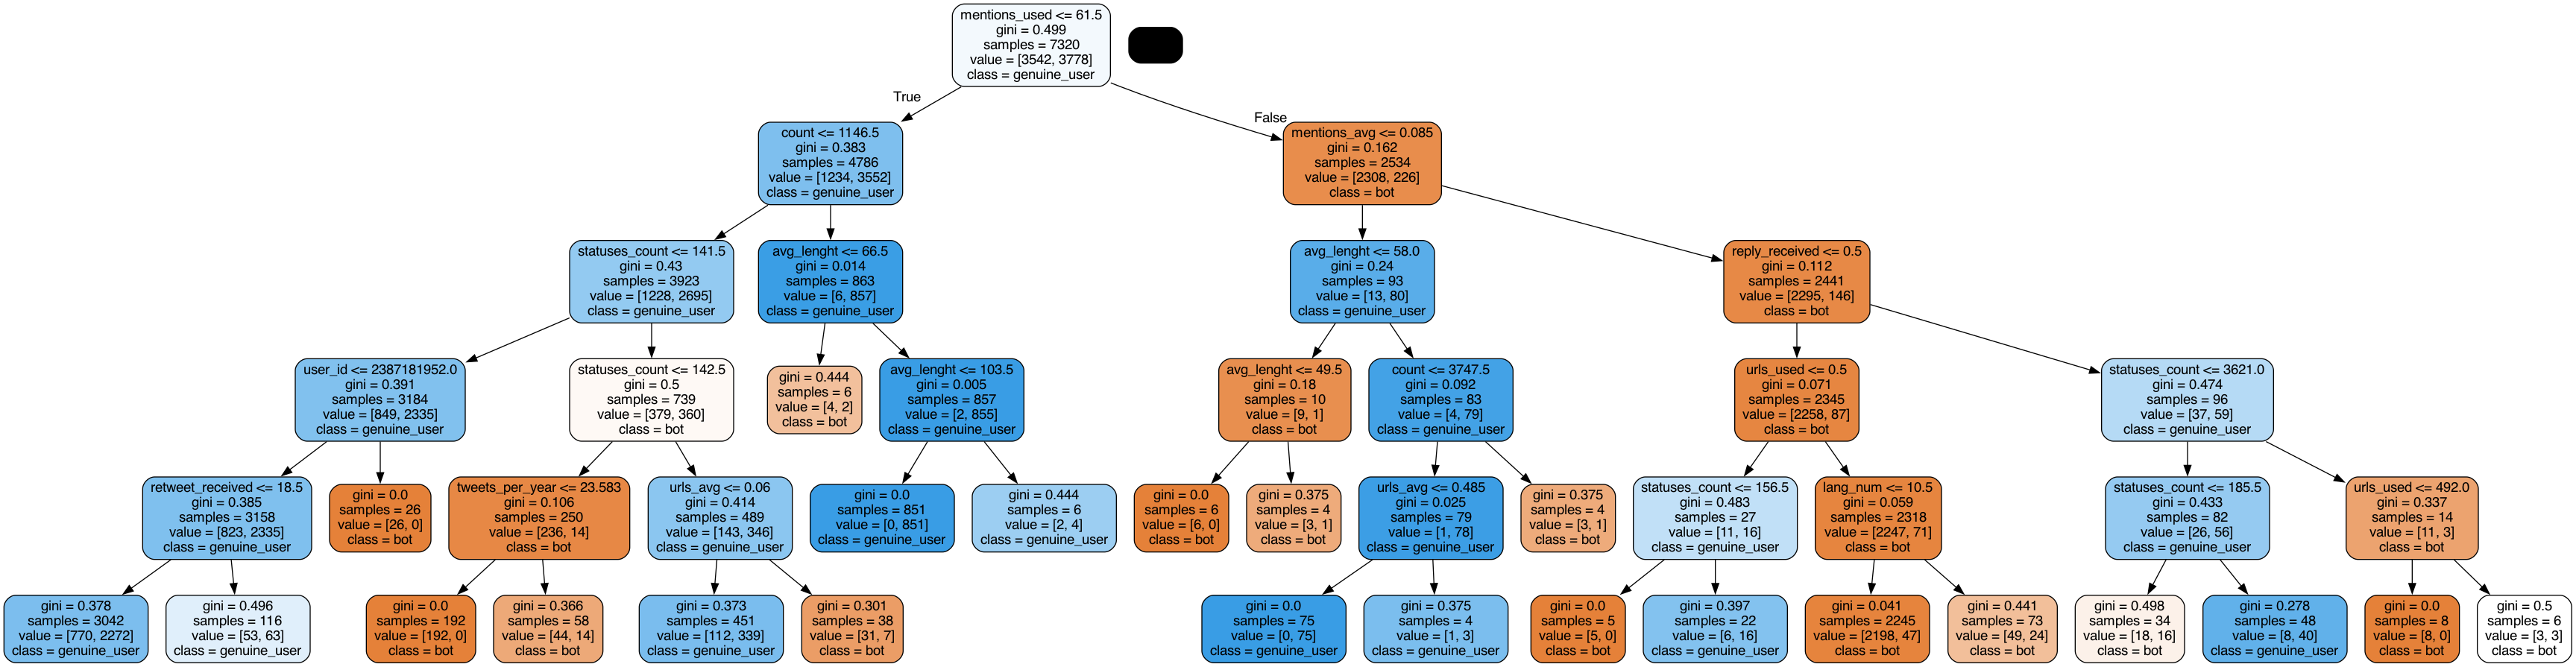

In [93]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['bot', 'genuine_user'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [94]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

##### Evaluation of Decision Tree Classification

In [95]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8542349726775956
Accuracy test set  0.8444869343530912
Precision train set  0.8729611318015041
Recall train set  0.8542349726775956
F1 score train set  0.8517381379895673
Support train set  (array([0.95748614, 0.79371614]), array([0.7312253 , 0.96956061]), array([0.82919802, 0.87287025]), array([3542, 3778]))


In [96]:
report_scores(train_label, train_pred_dt)

              precision    recall  f1-score   support

         bot       0.96      0.73      0.83      3542
genuine_user       0.79      0.97      0.87      3778

    accuracy                           0.85      7320
   macro avg       0.88      0.85      0.85      7320
weighted avg       0.87      0.85      0.85      7320



In [97]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         bot       0.94      0.72      0.82      1518
genuine_user       0.79      0.96      0.86      1620

    accuracy                           0.84      3138
   macro avg       0.86      0.84      0.84      3138
weighted avg       0.86      0.84      0.84      3138



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


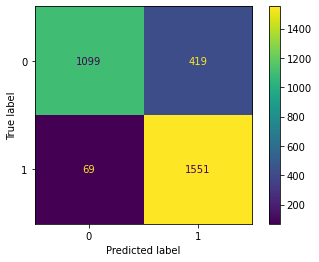

In [98]:
plot_confusion_matrix(dt, test_set, test_label)
plt.show()

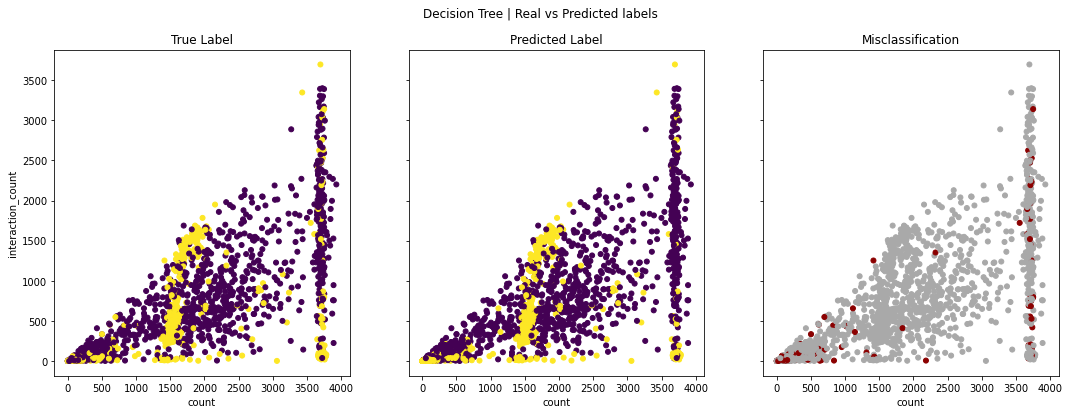

In [99]:
plot_prediction_data(test_set, test_label, test_pred_dt, 'Decision Tree', 'count', 'interaction_count')

#### Gaussian Naive Bayes

In [100]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

GaussianNB()

In [101]:
train_pred_gnb = gnb.predict(train_set)

In [102]:
test_pred_gnb = gnb.predict(test_set)

##### Gaussian Naive Bayes evaluation

In [103]:
report_scores(train_label, train_pred_gnb)

              precision    recall  f1-score   support

         bot       0.97      0.21      0.34      3542
genuine_user       0.57      0.99      0.73      3778

    accuracy                           0.61      7320
   macro avg       0.77      0.60      0.54      7320
weighted avg       0.76      0.61      0.54      7320



In [104]:
#compute the performance of the model
report_scores(test_label, test_pred_gnb)

              precision    recall  f1-score   support

         bot       0.95      0.23      0.37      1518
genuine_user       0.58      0.99      0.73      1620

    accuracy                           0.62      3138
   macro avg       0.77      0.61      0.55      3138
weighted avg       0.76      0.62      0.55      3138



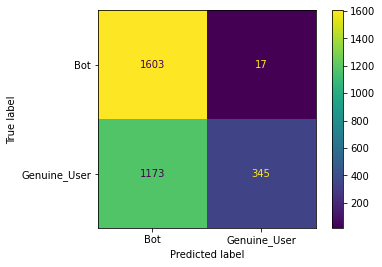

In [105]:
plot_confusion_mx(test_label, test_pred_gnb)

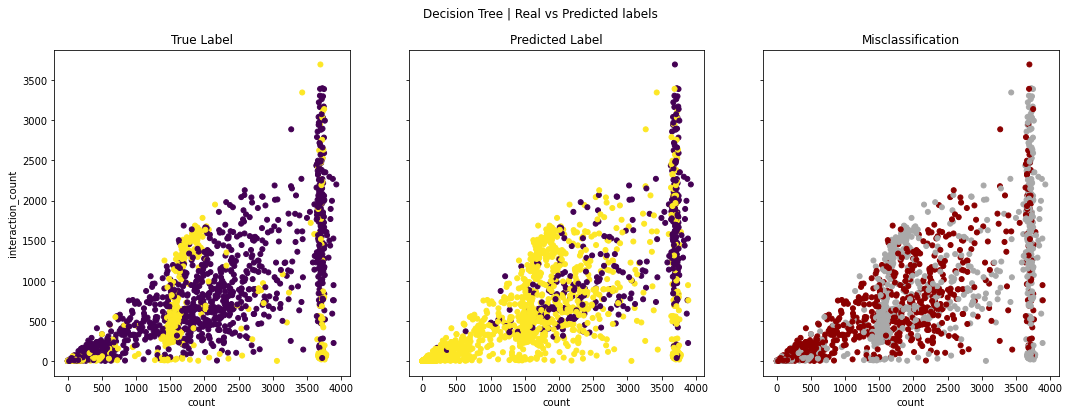

In [106]:
plot_prediction_data(test_set, test_label, test_pred_gnb, 'Decision Tree', 'count', 'interaction_count')

#### Classification with Random Forest

##### Parameter setting 

In [107]:
#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.3, 1: 0.7}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14fd61cf0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14fce6740>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14fce4c70>},
                   scoring=make_scorer(accuracy_score))

In [108]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 50, 'min_samples_split': 37}
Mean and std of this setting  0.842896174863388 0.009708108199147449


In [109]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=14,
                             max_depth=2, 
                             min_samples_split=18,
                             min_samples_leaf=43,
                             bootstrap=False) 
rf = rf.fit(train_set, train_label)

In [110]:
#prediction on the test test
train_pred_rf = rf.predict(train_set)

In [111]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

##### Random Forest Classification evaluation

In [112]:
report_scores(train_label, train_pred_rf)

              precision    recall  f1-score   support

         bot       0.94      0.65      0.77      3542
genuine_user       0.75      0.96      0.84      3778

    accuracy                           0.81      7320
   macro avg       0.84      0.81      0.80      7320
weighted avg       0.84      0.81      0.80      7320



In [113]:
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

         bot       0.93      0.65      0.77      1518
genuine_user       0.75      0.95      0.84      1620

    accuracy                           0.81      3138
   macro avg       0.84      0.80      0.80      3138
weighted avg       0.83      0.81      0.80      3138



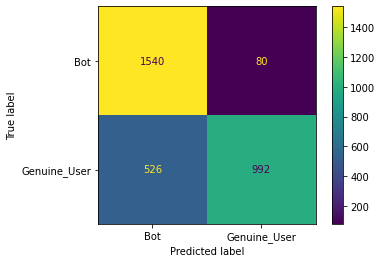

In [114]:
plot_confusion_mx(test_label, test_pred_rf)

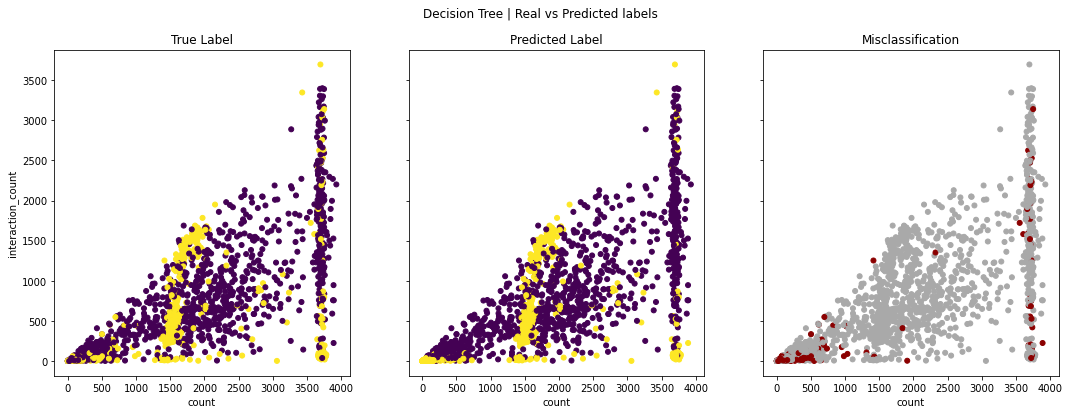

In [115]:
plot_prediction_data(test_set, test_label, test_pred_rf, 'Decision Tree', 'count', 'interaction_count')

#### AdaBoost Classfication

In [116]:
clf = AdaBoostClassifier()
clf.fit(train_set, train_label)

AdaBoostClassifier()

In [117]:
train_pred_clf = clf.predict(train_set)

In [118]:
test_pred_clf = clf.predict(test_set)

##### Evaluation of AdaBoost Classification

In [119]:
report_scores(train_label, train_pred_clf)

              precision    recall  f1-score   support

         bot       0.96      0.73      0.83      3542
genuine_user       0.80      0.97      0.87      3778

    accuracy                           0.86      7320
   macro avg       0.88      0.85      0.85      7320
weighted avg       0.87      0.86      0.85      7320



In [120]:
report_scores(test_label, test_pred_clf)

              precision    recall  f1-score   support

         bot       0.94      0.73      0.82      1518
genuine_user       0.79      0.96      0.87      1620

    accuracy                           0.85      3138
   macro avg       0.87      0.84      0.84      3138
weighted avg       0.86      0.85      0.85      3138



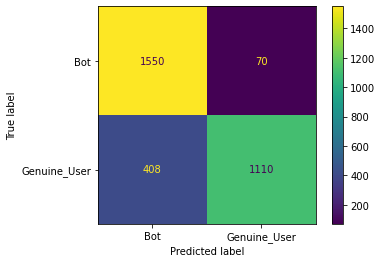

In [121]:
plot_confusion_mx(test_label, test_pred_clf)

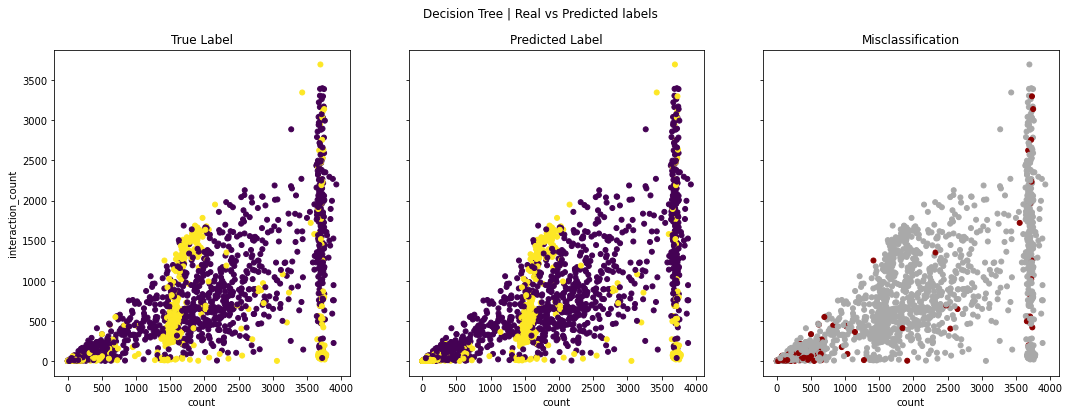

In [122]:
plot_prediction_data(test_set, test_label, test_pred_clf, 'Decision Tree', 'count', 'interaction_count')

#### AdaBoost with base classifier

In [123]:
#TODO: rivedere parametro max_depth
base = tree.DecisionTreeClassifier(max_depth=2)
clf = AdaBoostClassifier(base_estimator=base, n_estimators=200, learning_rate=0.1)
clf.fit(train_set, train_label)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=200)

In [124]:
train_pred_clf = clf.predict(train_set)

In [125]:
test_pred_clf = clf.predict(test_set)

##### Evaluation of AdaBoost with base classifier

In [126]:
report_scores(train_label, train_pred_clf)

              precision    recall  f1-score   support

         bot       0.99      0.75      0.85      3542
genuine_user       0.81      0.99      0.89      3778

    accuracy                           0.87      7320
   macro avg       0.90      0.87      0.87      7320
weighted avg       0.89      0.87      0.87      7320



In [127]:
report_scores(test_label, test_pred_clf)

              precision    recall  f1-score   support

         bot       0.96      0.74      0.83      1518
genuine_user       0.80      0.97      0.88      1620

    accuracy                           0.86      3138
   macro avg       0.88      0.85      0.85      3138
weighted avg       0.88      0.86      0.86      3138



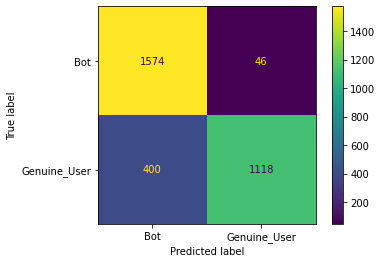

In [128]:
plot_confusion_mx(test_label, test_pred_clf)

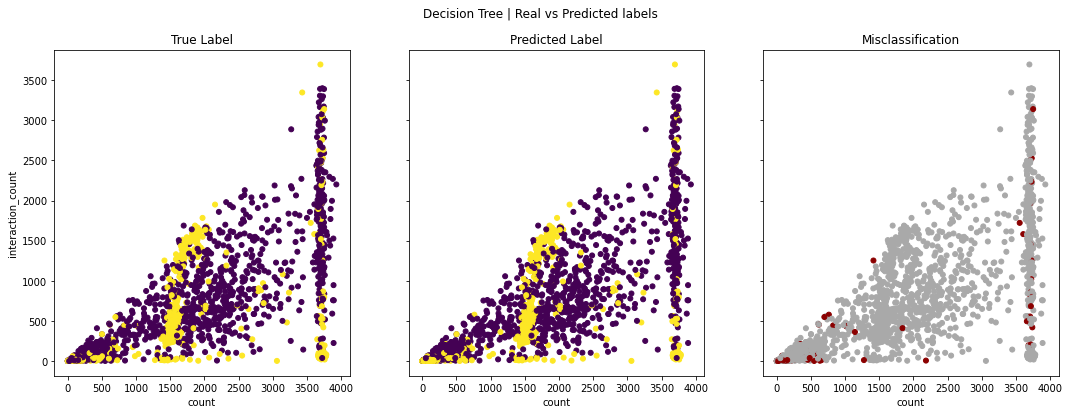

In [129]:
plot_prediction_data(test_set, test_label, test_pred_clf, 'Decision Tree', 'count', 'interaction_count')

#### SVM

In [130]:
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)

SVC(C=0.5, kernel='sigmoid', probability=True)

In [131]:
train_pred_svm = svm.predict(train_set)

In [132]:
test_pred_svm = svm.predict(test_set)

In [133]:
report_scores(train_label, train_pred_svm)

              precision    recall  f1-score   support

         bot       0.46      0.46      0.46      3542
genuine_user       0.49      0.49      0.49      3778

    accuracy                           0.48      7320
   macro avg       0.48      0.48      0.48      7320
weighted avg       0.48      0.48      0.48      7320



In [134]:
report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

         bot       0.44      0.43      0.43      1518
genuine_user       0.48      0.49      0.48      1620

    accuracy                           0.46      3138
   macro avg       0.46      0.46      0.46      3138
weighted avg       0.46      0.46      0.46      3138



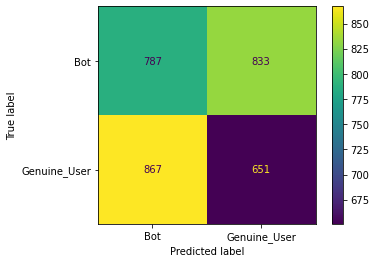

In [135]:
plot_confusion_mx(test_label, test_pred_svm)

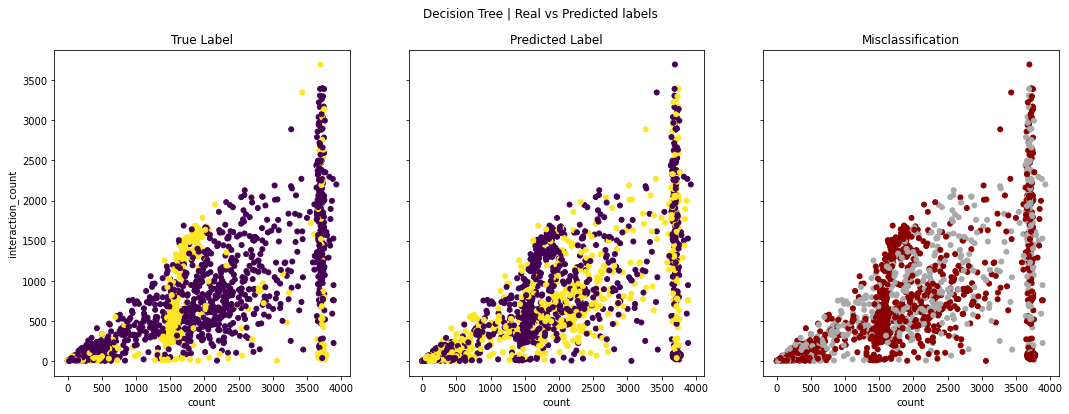

In [136]:
plot_prediction_data(test_set, test_label, test_pred_svm, 'Decision Tree', 'count', 'interaction_count')

#### Rule Based

In [137]:
#we searching for best configuration parameters
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)
grid_search.fit(train_set, train_label)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

GridSearchCV(estimator=<RIPPER(n_discretize_bins=10, dl_allowance=64, max_rule_conds=None, prune_size=0.33, max_total_conds=None, max_rules=None, k=2, verbosity=0, random_state=None)>,
             param_grid={'k': [1, 3, 5], 'prune_size': [0.5, 0.6]})

In [138]:
#grid_result = grid_search.fit(train_set, train_label, pos_class=1)
grid_search.cv_results_['params'][0]

{'k': 1, 'prune_size': 0.5}

In [139]:
ripper = lw.RIPPER(k=1, prune_size=0.5)
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='bot', pos_class=1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

In [140]:
ripper.out_model()

[[urls_used=<3.0 ^ statuses_count=35.0-90.0 ^ mentions_avg=0.01-0.14 ^ favorite_received=1.0-3.0 ^ tweets_per_year=<5.27 ^ urls_avg=<0.02] V
[urls_used=<3.0 ^ statuses_count=<35.0 ^ interaction_count=<2.0 ^ activity_period=19.0-23.0] V
[urls_used=<3.0 ^ activity_period=4.0-5.0 ^ statuses_count=90.0-111.0 ^ interaction_count=5.0-7.0 ^ favorite_received=3.0-5.0] V
[urls_used=<3.0 ^ statuses_count=90.0-111.0 ^ favorite_received=5.0-7.0] V
[retweet_max=<1.0 ^ mentions_avg=<0.01 ^ urls_used=>450.2] V
[urls_avg=<0.02 ^ mentions_avg=<0.01 ^ statuses_count=1150.4-2007.3] V
[urls_used=<3.0 ^ favorite_max=1.0-2.0 ^ avg_lenght=65.0-68.0 ^ statuses_count=35.0-90.0] V
[urls_used=<3.0 ^ statuses_count=111.0-132.0] V
[urls_used=<3.0 ^ retweet_received=<2.0 ^ statuses_count=35.0-90.0] V
[urls_used=<3.0 ^ statuses_count=90.0-111.0 ^ retweet_received=<2.0 ^ mentions_used=17.0-35.0] V
[urls_used=<3.0 ^ statuses_count=<35.0 ^ user_id=1128285022.0-2212991933.0] V
[urls_used=<3.0 ^ activity_period=4.0-5.0 ^

In [141]:
train_pred_ripper = ripper.predict(train_set)
test_pred_ripper = ripper.predict(test_set)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

In [142]:
report_scores(train_label, train_pred_ripper)

              precision    recall  f1-score   support

         bot       0.88      0.73      0.80      3542
genuine_user       0.78      0.91      0.84      3778

    accuracy                           0.82      7320
   macro avg       0.83      0.82      0.82      7320
weighted avg       0.83      0.82      0.82      7320



In [143]:
report_scores(test_label, test_pred_ripper)

              precision    recall  f1-score   support

         bot       0.88      0.70      0.78      1518
genuine_user       0.77      0.91      0.83      1620

    accuracy                           0.81      3138
   macro avg       0.83      0.81      0.81      3138
weighted avg       0.82      0.81      0.81      3138



In [144]:
#evaluation of the performance of the classifier (test set)
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

Accuracy  0.8126195028680688


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

Precision  0.7676348547717843


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

Recall  0.9135802469135802


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is dep

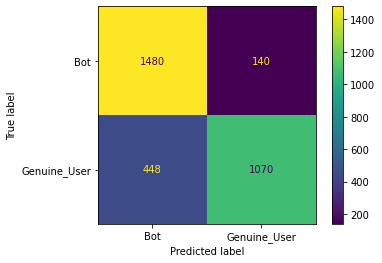

In [145]:
plot_confusion_mx(test_label, test_pred_ripper)

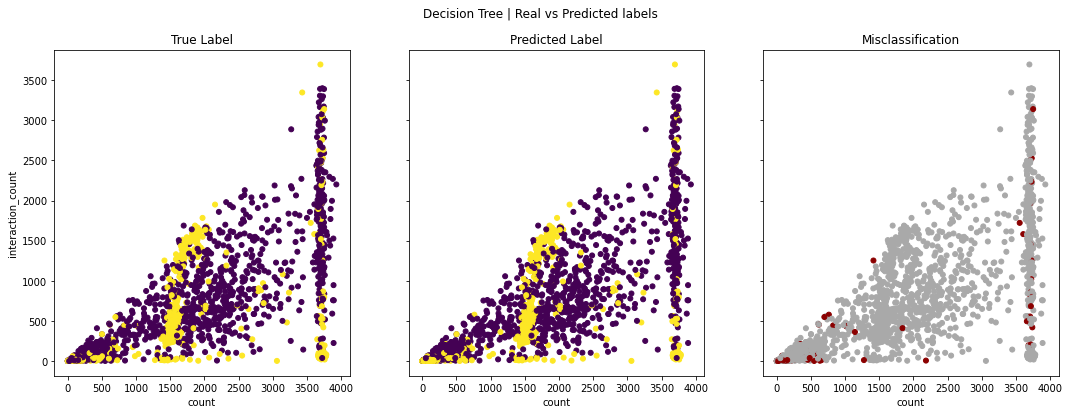

In [146]:
plot_prediction_data(test_set, test_label, test_pred_clf, 'Decision Tree', 'count', 'interaction_count')

#### Neural Network

In [224]:
import tensorflow as tf
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(1, len(train_set.columns))),
        tf.keras.layers.Dense(60, activation='relu'),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dropout(0.17),    
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [225]:
x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
history = model.fit(x_train, train_label,
                    epochs=60,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/60
92/92 [==============================] - 19s 55ms/step - loss: 0.0000e+00 - accuracy: 0.4838 - val_loss: 0.0000e+00 - val_accuracy: 0.4829
Epoch 2/60
92/92 [==============================] - 2s 24ms/step - loss: 0.0000e+00 - accuracy: 0.4841 - val_loss: 0.0000e+00 - val_accuracy: 0.4829
Epoch 3/60
92/92 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - accuracy: 0.4841 - val_loss: 0.0000e+00 - val_accuracy: 0.4829
Epoch 4/60
92/92 [==============================] - 3s 29ms/step - loss: 0.0000e+00 - accuracy: 0.4841 - val_loss: 0.0000e+00 - val_accuracy: 0.4829
Epoch 5/60
92/92 [==============================] - 3s 32ms/step - loss: 0.0000e+00 - accuracy: 0.4841 - val_loss: 0.0000e+00 - val_accuracy: 0.4829
Epoch 6/60
92/92 [==============================] - 2s 17ms/step - loss: 0.0000e+00 - accuracy: 0.4841 - val_loss: 0.0000e+00 - val_accuracy: 0.4829
Epoch 7/60
92/92 [==============================] - 2s 22ms/step - loss: 0.0000e+00 - accuracy: 0.4841 - 

In [214]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 21)                0         
                                                                 
 dense_60 (Dense)            (None, 15)                330       
                                                                 
 dropout_27 (Dropout)        (None, 15)                0         
                                                                 
 dense_61 (Dense)            (None, 15)                240       
                                                                 
 dropout_28 (Dropout)        (None, 15)                0         
                                                                 
 dense_62 (Dense)            (None, 1)                 16        
                                                                 
Total params: 586
Trainable params: 586
Non-trainable

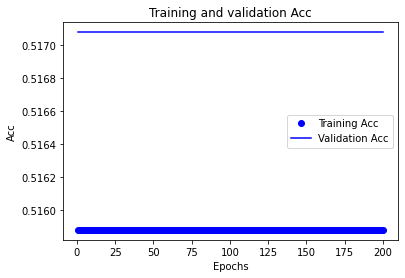

In [215]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [216]:
x_test = np.reshape(test_set.values, (len(test_set), 1, len(train_set.columns)))
test_pred_nn = (model.predict(x_test) > 0.4).astype("int32")

99/99 [==============================] - 0s 2ms/step


In [217]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

         bot       0.00      0.00      0.00      1518
genuine_user       0.52      1.00      0.68      1620

    accuracy                           0.52      3138
   macro avg       0.26      0.50      0.34      3138
weighted avg       0.27      0.52      0.35      3138



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### K-Nearest Neighbour

### Classification with weight

### Classification with oversampling with SMOTE

In [ ]:
oversample = SMOTE(sampling_strategy=0.3)
training, labels = oversample.fit_resample(train_set, train_label)

ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.